## Predicting Stock Price Using ARIMA Model
### by Wenzhe Ding

In this project we will perform time series prediction - predicting annual common stock price of U.S. - using an ARIMA model. ARIMA is an acronym that stands for AutoRegressive Integrated Moving Average. 
* AR: Autoregression. A model that uses the dependent relationship between an observation and several lagged observations.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

Typically, we use ARIMA(p,d,q) to indicate the specific ARIMA model being used. The parameters of the ARIMA model are defined as follows:
* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

## Table of contents
- [Data Processing](#DataProcessing)
- [Build an ARIMA regression model](#ARIMA)
- [Evaluate model performance](#Evaluate)

----
<a id='DataProcessing'></a>
## Data Processing
[[ go back to the top ]](#Table-of-contents)

We obtained annual common stock price data of U.S. from 1871 to 1969 [here](https://datamarket.com/data/set/22lm/annual-common-stock-price-us-1871-to-1970#!ds=22lm&display=line). First we must load in our time serie data - a history of around 98 years of annual common stock price. 

In [1]:
### Load in necessary libraries for data input and normalization
import pandas as pd
import numpy as np
import string
from collections import Counter
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def line_plot(data, title, xlabel, ylabel):
    pplt = data.plot(marker='o', figsize=(15, 6))
    pplt.set_title(title)
    pplt.set_xlabel(xlabel, fontsize=20)
    pplt.set_ylabel(ylabel, fontsize=20)

In [3]:
### load in and normalize the dataset
raw_data = pd.read_csv('datasets/annual-common-stock-price-us-187.csv')
raw_data.head()

,Year,Annual common stock price US 1871 to 1970
0,1871,5.03
1,1872,4.80
2,1873,4.57
3,1874,4.45
4,1875,4.06


In [4]:
data = raw_data[["Annual common stock price US 1871 to 1970"]]
raw_data = raw_data.set_index("Year")

Lets take a quick look at the time series we'll be performing predictions on.

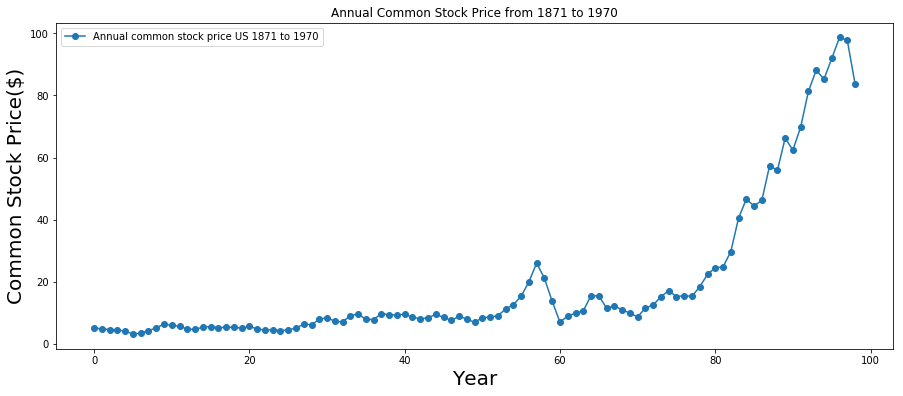

In [11]:
line_plot(data, "Annual Common Stock Price from 1871 to 1970", 'Year', 'Common Stock Price($)')

We can see that the Common Stock Price dataset has a clear trend - the time series is not stationary and will require differencing to make it stationary, at least a difference order of 1. Let’s also take another look at an autocorrelation plot of the time series. 

In [13]:
from pandas.plotting import autocorrelation_plot

/Users/wding/anaconda3/envs/carnd-advdl-odlab/lib/python3.6/site-packages/matplotlib/pyplot.py:984: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


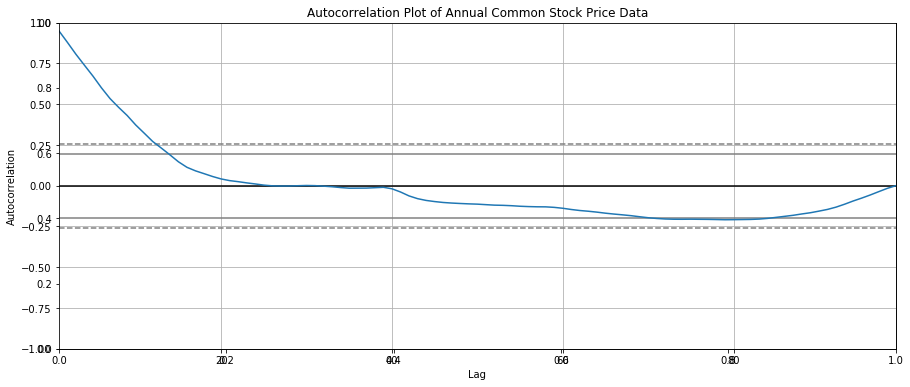

In [27]:
plt.figure(figsize=(15, 6))
plt.title("Autocorrelation Plot of Annual Common Stock Price Data")
autocorrelation_plot(data)

From the graph above, there is a positive correlation with the first 35-to-40 lags that is most significant for the first 10 lags. We will first start using 5 for the AR parameter of the model.

----
<a id='ARIMA'></a>
## Build an ARIMA model
[[ go back to the top ]](#Table-of-contents)

We can now begin setting up our ARMIMA model.  We use statsmodels to quickly fit an ARIMA(5,1,0) model, This sets the lag value to 10 for autoregression, uses a difference order of 1 to make the time series stationary, and uses a moving average model of 0. The summary below shows the coefficient values used as well as the level of the fit of all the observations.

In [18]:
# given - fix random seed - so we can all reproduce the same results on our default time series
from statsmodels.tsa.arima_model import ARIMA

In [33]:
# fit model
model = ARIMA(data, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                          ARIMA Model Results                                          
Dep. Variable:     D.Annual common stock price US 1871 to 1970   No. Observations:                   98
Model:                                          ARIMA(5, 1, 0)   Log Likelihood                -256.795
Method:                                                css-mle   S.D. of innovations              3.317
Date:                                         Mon, 09 Jul 2018   AIC                            527.590
Time:                                                 19:32:50   BIC                            545.685
Sample:                                                      1   HQIC                           534.909
                                                                                                       
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

Here we plot the residual errors, suggesting that there may still be some trend information not captured by the model. we also obtain a density plot of the residual error values, suggesting the errors are close to standard Gaussian.

Description of Residuals                0
count  98.000000
mean    0.007498
std     3.334166
min   -12.175366
25%    -1.112728
50%    -0.184139
75%     0.909792
max    12.443349


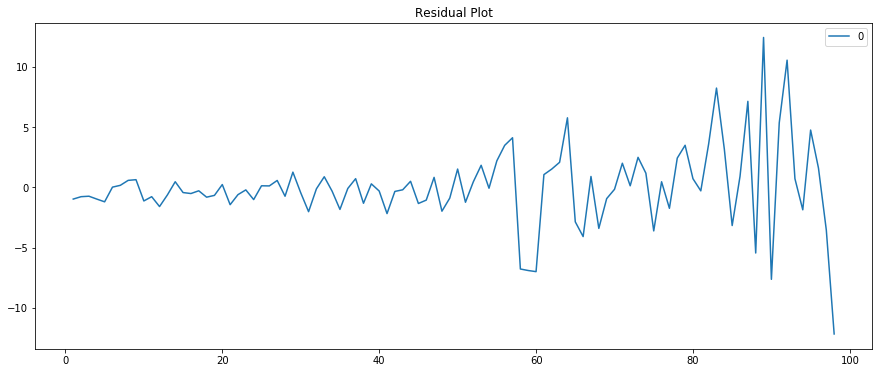

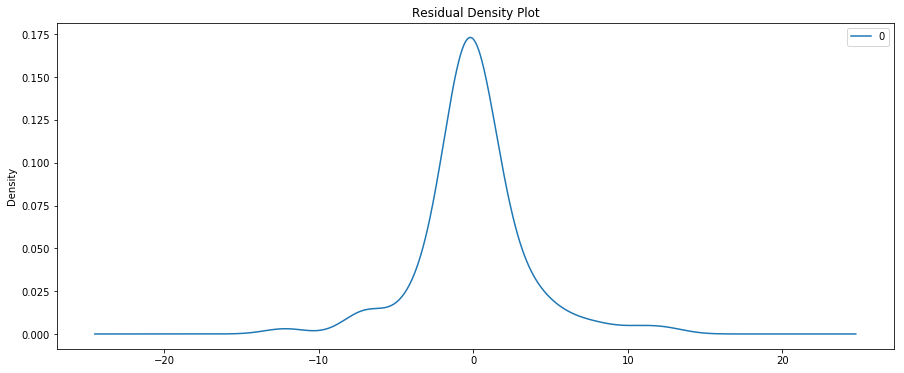

In [39]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(figsize=(15, 6), title = "Residual Plot")

residuals.plot(kind='kde', figsize=(15, 6), title = "Residual Density Plot")
print("Description of Residuals",s residuals.describe())

----
<a id='Evaluate'></a>
## Evaluate model performance
[[ go back to the top ]](#Table-of-contents)

With our model fit we can now make predictions on our data. We use `mean_squared_error`(MSE) to estimate our model's performance.

In [40]:
from sklearn.metrics import mean_squared_error

In [41]:
X = data.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit(disp=0)
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
# 	print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 38.195


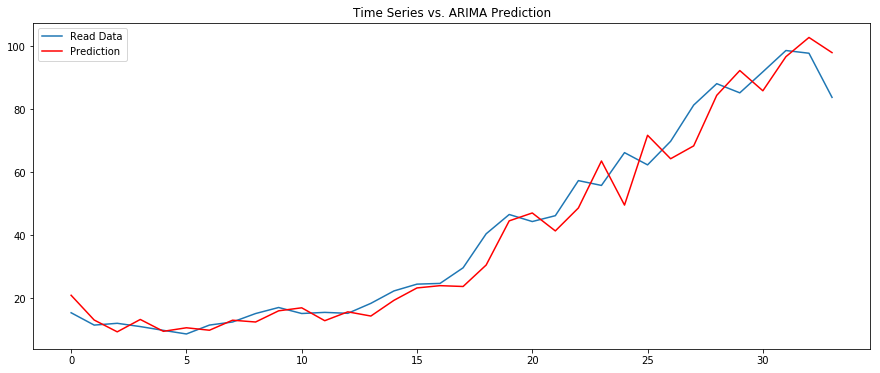

In [48]:
plt.figure(figsize=(15,6))
plt.plot(test, label = "Read Data")
plt.plot(predictions, color='red', label = "Prediction")
plt.legend()
plt.title("Time Series vs. ARIMA Prediction")
plt.show()

We could further tuning three parameters but our model is able to capture the general trend of the time series. 